# 06 - Geometric Skeleton & Stained Glass Visualization

This notebook introduces the **spatial tree representation** with stained-glass poster aesthetics.

**Key features:**
- Depth-8 binary tree skeleton (255 segments, 128 tips)
- Bilateral symmetry for natural, balanced forms
- Poisson-disk sampled canopy for dense leaf coverage
- Lead-came style branch rendering
- Coleus-style variegated leaves

**This enables:**
- **Spatial light capture**: Higher leaves get more light, shading below
- **Wind exposure**: Position and orientation affect vulnerability
- **Stained-glass aesthetics**: Geometric, symbolic tree forms
- **"Every Tree is Bonsai"**: Stress → form relationship

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from sim.skeleton import (
    SkeletonState,
    create_grown_skeleton,
    compute_segment_positions_2d,
    compute_light_capture,
    compute_wind_exposure,
    get_tip_indices,
)
from sim.visualization import (
    render_stained_glass_tree,
    render_comparison,
    AUTUMN_PALETTE,
    SPRING_PALETTE,
    SUNSET_PALETTE,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

## 1. Skeleton Complexity: Depth Comparison

The skeleton depth determines visual richness:
- Depth 4: 15 segments, 8 tips (sparse)
- Depth 8: 255 segments, 128 tips (dense, poster-quality)

In [2]:
# Compare skeleton complexity
print("Skeleton complexity by depth:")
print("-" * 40)
for depth in [4, 5, 6, 7, 8]:
    num_segments = 2**depth - 1
    num_tips = 2**(depth - 1)
    print(f"Depth {depth}: {num_segments:>3} segments, {num_tips:>3} tips")

Skeleton complexity by depth:
----------------------------------------
Depth 4:  15 segments,   8 tips
Depth 5:  31 segments,  16 tips
Depth 6:  63 segments,  32 tips
Depth 7: 127 segments,  64 tips
Depth 8: 255 segments, 128 tips


In [3]:
# Create trees at different depths
depth_4 = create_grown_skeleton(depth=4, growth_stage=1.0, prune_fraction=0.1, seed=42)
depth_6 = create_grown_skeleton(depth=6, growth_stage=1.0, prune_fraction=0.15, seed=42)
depth_8 = create_grown_skeleton(depth=8, growth_stage=1.0, prune_fraction=0.2, seed=42)

print(f"Depth 4: {sum(1 for a in depth_4.alive if float(a) > 0.5)} alive branches")
print(f"Depth 6: {sum(1 for a in depth_6.alive if float(a) > 0.5)} alive branches")
print(f"Depth 8: {sum(1 for a in depth_8.alive if float(a) > 0.5)} alive branches")

Depth 4: 13 alive branches
Depth 6: 33 alive branches
Depth 8: 67 alive branches


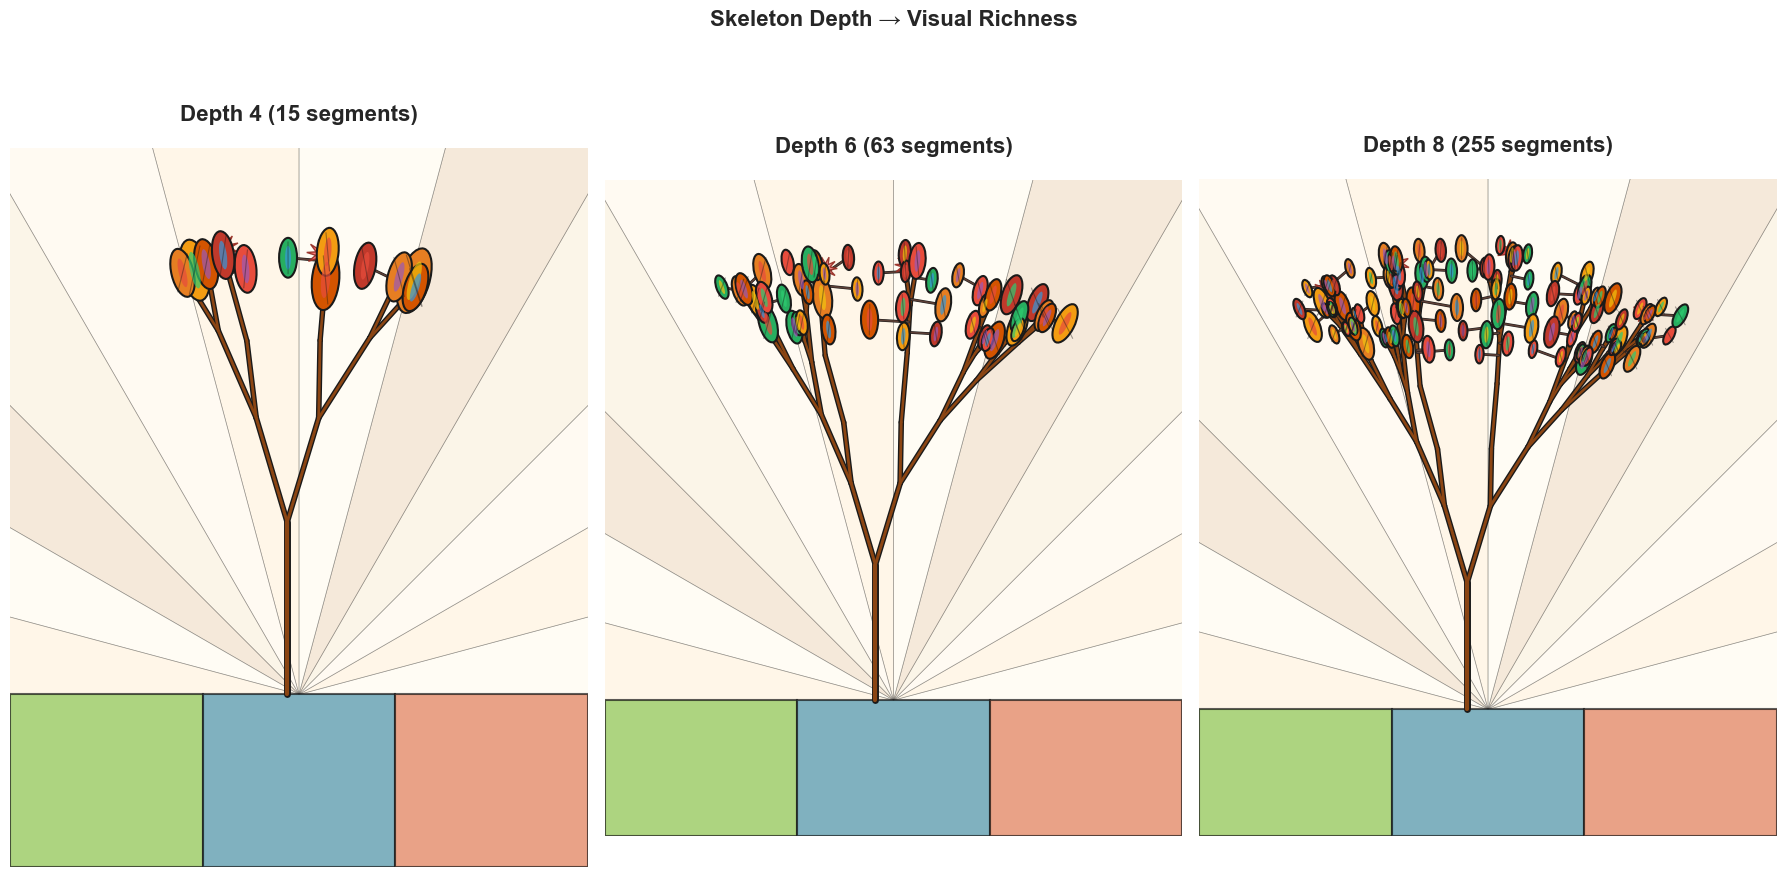

In [4]:
# Side-by-side depth comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

render_stained_glass_tree(depth_4, ax=axes[0], leaf_density=40, leaf_size=0.15, title='Depth 4 (15 segments)')
render_stained_glass_tree(depth_6, ax=axes[1], leaf_density=80, leaf_size=0.12, title='Depth 6 (63 segments)')
render_stained_glass_tree(depth_8, ax=axes[2], leaf_density=180, leaf_size=0.1, title='Depth 8 (255 segments)')

plt.suptitle('Skeleton Depth → Visual Richness', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Stained Glass Hero Image

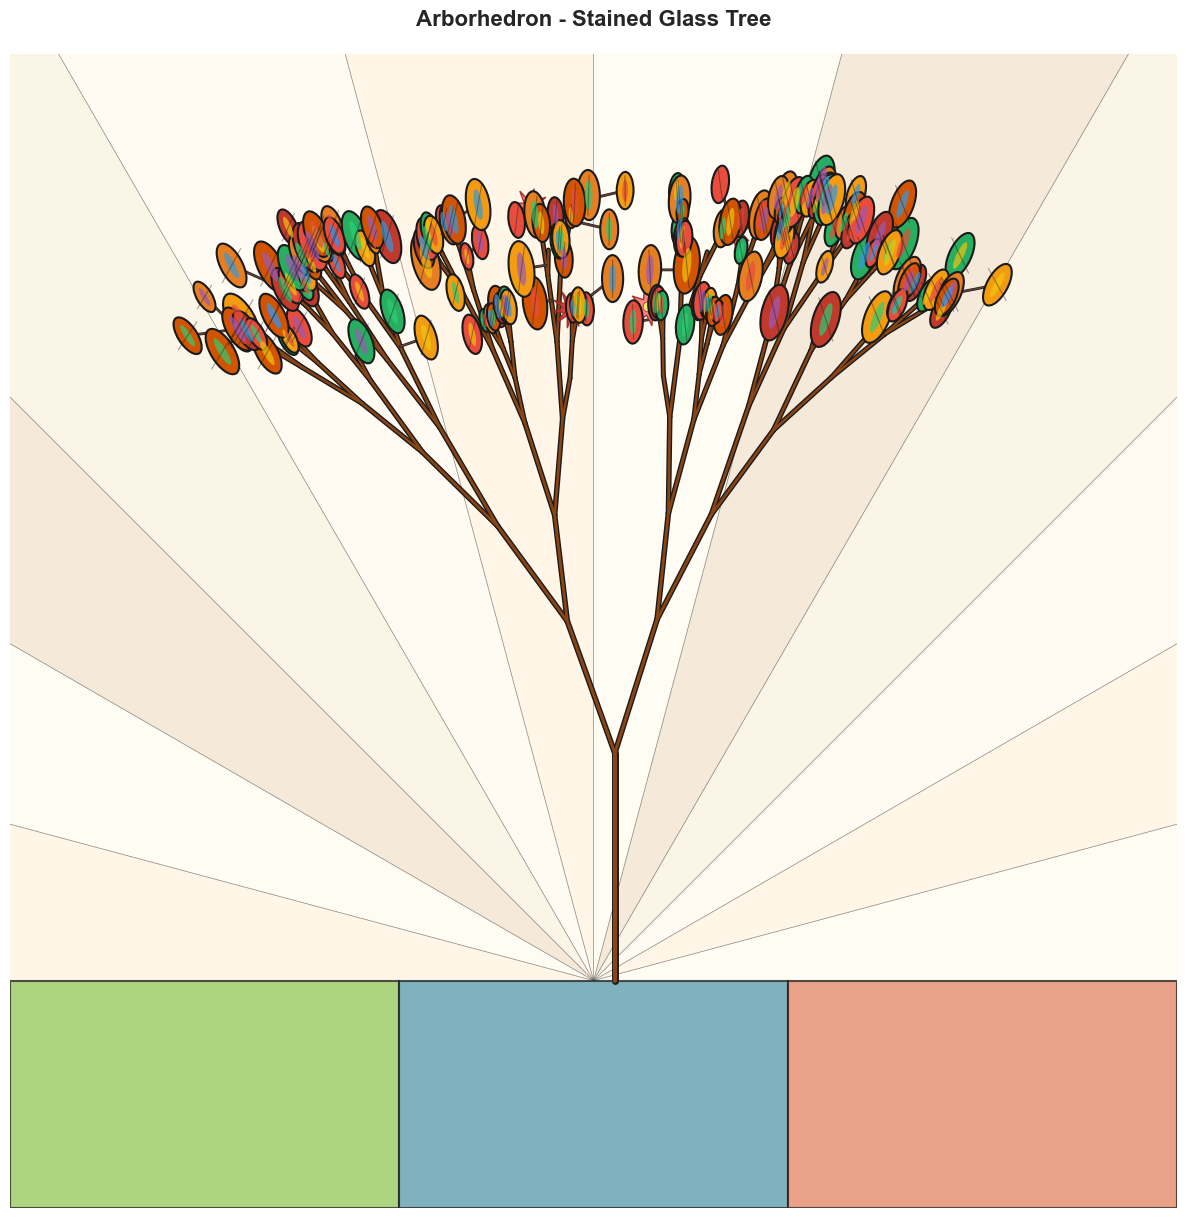

In [5]:
# Create a lush tree
hero_tree = create_grown_skeleton(
    depth=8,
    growth_stage=1.0,
    prune_fraction=0.18,
    jitter_strength=0.08,
    symmetric=True,
    seed=123,
)

fig, ax = plt.subplots(figsize=(12, 14))
render_stained_glass_tree(
    hero_tree,
    ax=ax,
    leaf_density=220,
    leaf_size=0.1,
    palette=AUTUMN_PALETTE,
    title='Arborhedron - Stained Glass Tree',
    seed=42,
)
plt.tight_layout()
plt.savefig('stained_glass_hero.png', dpi=150, bbox_inches='tight', facecolor='#FFF8DC')
plt.show()

## 3. Environmental Stress → Tree Form

**"Every Tree is Bonsai"** - stress shapes form:
- Calm conditions → exuberant, full canopy
- Moderate stress → balanced pruning
- High stress → compact bonsai form

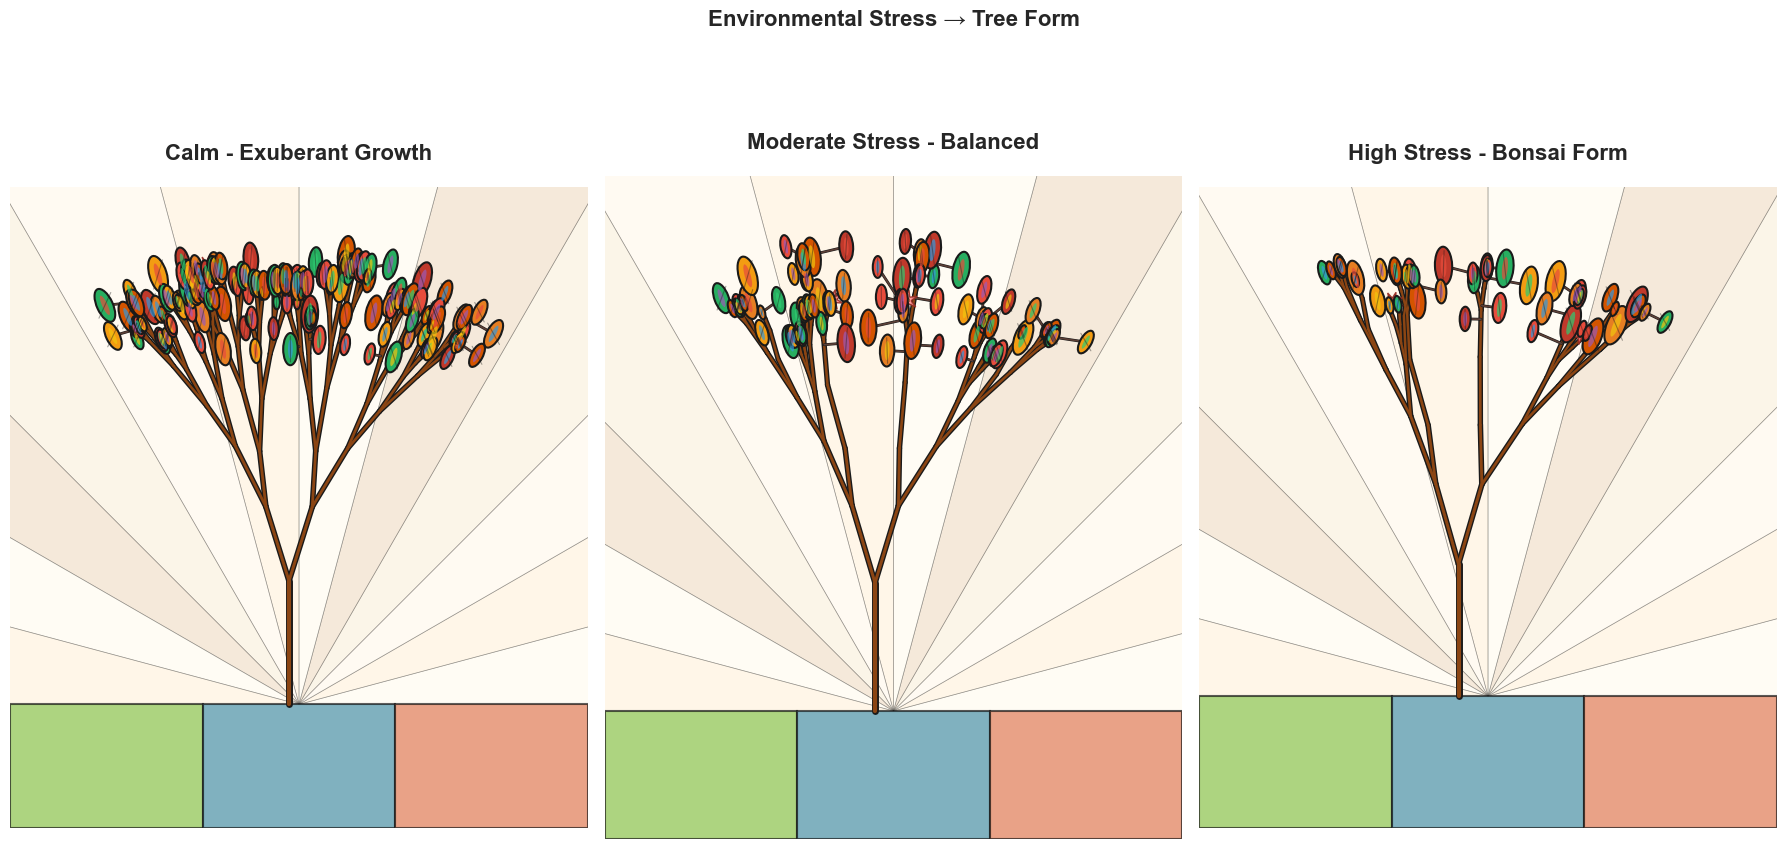

In [6]:
# Stress morphology comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Calm - lush growth
calm = create_grown_skeleton(depth=8, prune_fraction=0.1, jitter_strength=0.05, seed=42)
render_stained_glass_tree(calm, ax=axes[0], leaf_density=200, title='Calm - Exuberant Growth')

# Moderate stress
moderate = create_grown_skeleton(depth=8, prune_fraction=0.3, jitter_strength=0.1, seed=42)
render_stained_glass_tree(moderate, ax=axes[1], leaf_density=140, title='Moderate Stress - Balanced')

# High stress - bonsai
stressed = create_grown_skeleton(depth=8, prune_fraction=0.5, jitter_strength=0.15, seed=42)
render_stained_glass_tree(stressed, ax=axes[2], leaf_density=70, title='High Stress - Bonsai Form')

plt.suptitle('Environmental Stress → Tree Form', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('stress_morphology.png', dpi=150, bbox_inches='tight', facecolor='#FFF8DC')
plt.show()

## 4. Light Capture and Self-Shading

Higher leaves capture more light and shade those below. This creates spatial competition within the canopy.

In [7]:
# Create a moderate-sized tree for light analysis (depth 6 for clearer visualization)
light_tree = create_grown_skeleton(depth=6, growth_stage=1.0, prune_fraction=0.15, seed=77)
light = compute_light_capture(light_tree)

# Statistics
tip_indices = get_tip_indices(light_tree.depth)
alive_tips = [i for i in tip_indices if float(light_tree.alive[int(i)]) > 0.3]

print(f"Tree has {len(alive_tips)} alive tips")
print(f"Total light capture: {float(jnp.sum(light)):.2f}")
print(f"Max light at single tip: {float(jnp.max(light)):.3f}")
print(f"Min light at alive tip: {min(float(light[int(i)]) for i in alive_tips if float(light[int(i)]) > 0):.3f}")

Tree has 28 alive tips
Total light capture: 0.39
Max light at single tip: 0.092
Min light at alive tip: 0.000


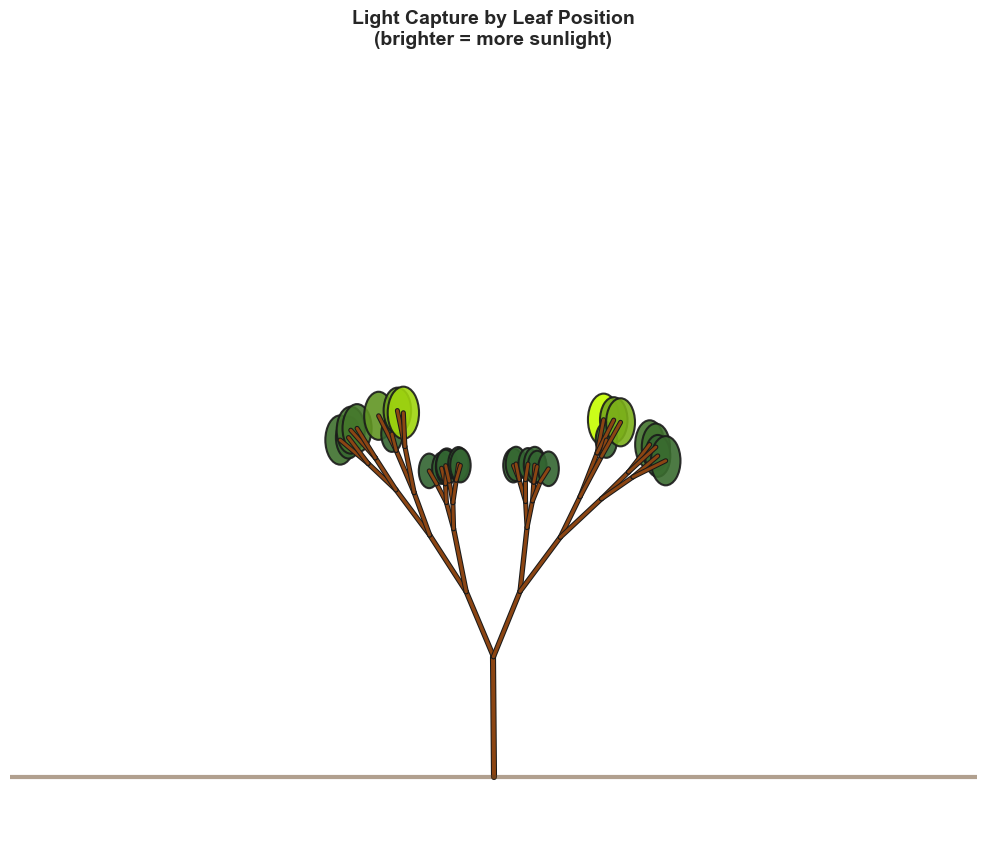

In [8]:
def draw_light_capture(skeleton, ax=None):
    """Draw tree with leaves colored by light capture (darker = shaded)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    light = compute_light_capture(skeleton)
    x, y, _ = compute_segment_positions_2d(skeleton)
    x, y = np.array(x), np.array(y)
    
    tip_indices = get_tip_indices(skeleton.depth)
    
    # Draw branches
    for idx in range(skeleton.num_segments):
        alive = float(skeleton.alive[idx])
        if alive < 0.1:
            continue
        
        if idx == 0:
            start_x, start_y = 0.0, 0.0
        else:
            parent = (idx - 1) // 2
            start_x, start_y = x[parent], y[parent]
        
        thickness = float(skeleton.thickness[idx])
        linewidth = 2 + 6 * thickness * alive
        
        # Lead-came style
        ax.plot([start_x, x[idx]], [start_y, y[idx]], 
                color='#1a1a1a', linewidth=linewidth + 1.5, solid_capstyle='round')
        ax.plot([start_x, x[idx]], [start_y, y[idx]], 
                color='#8B4513', linewidth=linewidth, solid_capstyle='round')
    
    # Draw leaves colored by light
    max_light = float(jnp.max(light)) + 0.001
    
    for tip_idx in tip_indices:
        tip_idx = int(tip_idx)
        leaf_area = float(skeleton.leaf_area[tip_idx])
        alive = float(skeleton.alive[tip_idx])
        light_val = float(light[tip_idx])
        
        if leaf_area * alive < 0.01:
            continue
        
        leaf_size = 0.08 + 0.15 * np.sqrt(leaf_area * alive)
        
        # Color: dark green (shaded) to bright yellow-green (full sun)
        light_frac = light_val / max_light
        r = int(50 + 150 * light_frac)
        g = int(100 + 155 * light_frac)
        b = int(50 * (1 - light_frac))
        color = f'#{r:02x}{g:02x}{b:02x}'
        
        ellipse = mpatches.Ellipse(
            (x[tip_idx], y[tip_idx]),
            width=leaf_size * 0.6,
            height=leaf_size,
            facecolor=color,
            edgecolor='#1a1a1a',
            linewidth=1.5,
            alpha=0.9,
        )
        ax.add_patch(ellipse)
    
    ax.set_facecolor('#FFF8DC')
    ax.axhline(0, color='#654321', linewidth=3, alpha=0.5)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax


fig, ax = plt.subplots(figsize=(10, 12))
draw_light_capture(light_tree, ax=ax)
ax.set_title('Light Capture by Leaf Position\n(brighter = more sunlight)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Wind Exposure Visualization

Wind exposure depends on:
- Height (higher = more exposed)
- Branch orientation (perpendicular to wind = more force)
- Downstream leaf load (more leaves = more drag)

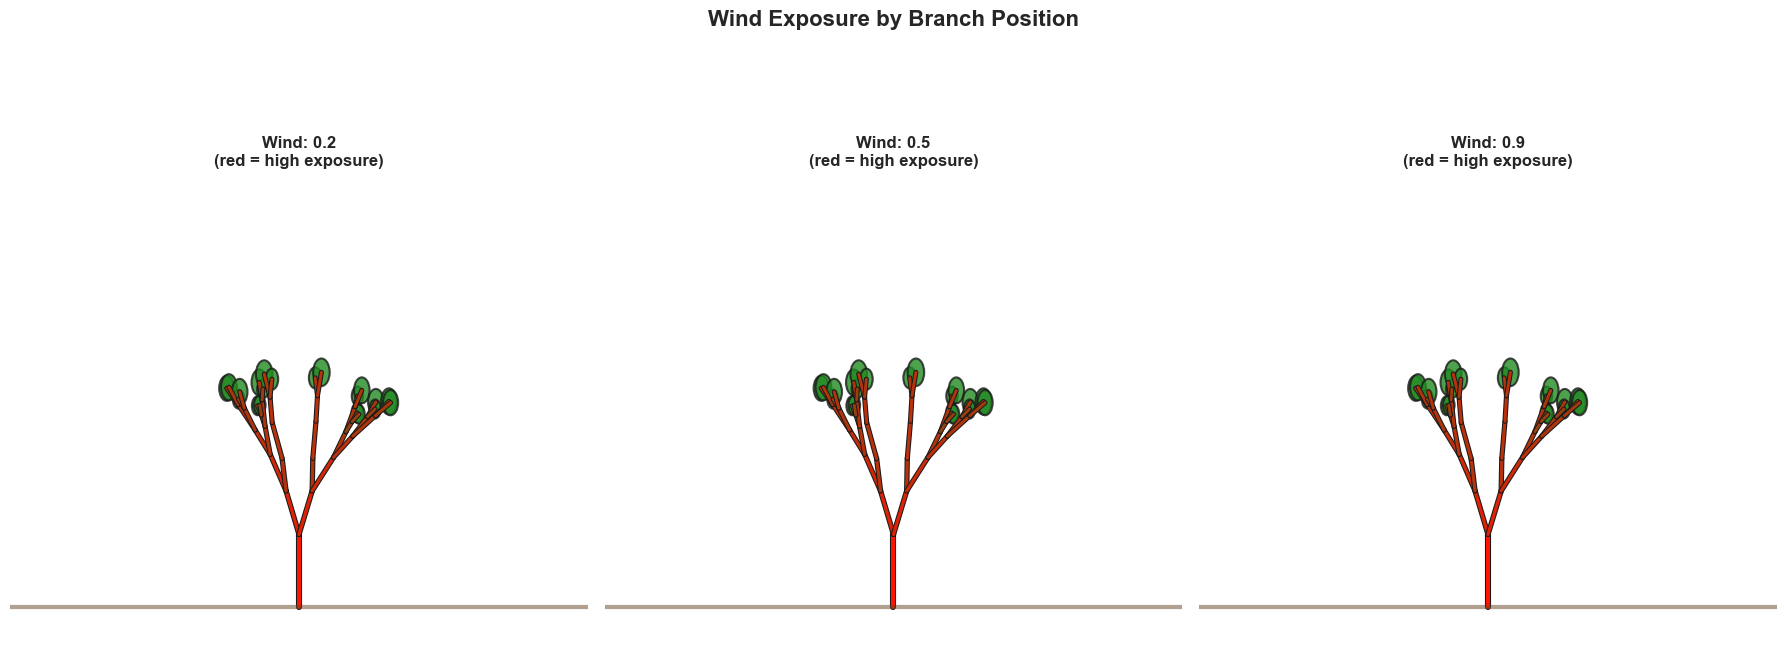

In [9]:
def draw_wind_exposure(skeleton, wind_speed, ax=None):
    """Draw tree with branches colored by wind exposure (red = high exposure)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    exposure = compute_wind_exposure(skeleton, wind_speed=wind_speed, wind_direction=0.0)
    x, y, _ = compute_segment_positions_2d(skeleton)
    x, y = np.array(x), np.array(y)
    
    max_exp = float(jnp.max(exposure)) + 0.001
    
    # Draw branches colored by exposure
    for idx in range(skeleton.num_segments):
        alive = float(skeleton.alive[idx])
        if alive < 0.1:
            continue
        
        if idx == 0:
            start_x, start_y = 0.0, 0.0
        else:
            parent = (idx - 1) // 2
            start_x, start_y = x[parent], y[parent]
        
        thickness = float(skeleton.thickness[idx])
        linewidth = 2 + 6 * thickness * alive
        
        # Color by exposure (brown -> orange -> red)
        exp_frac = float(exposure[idx]) / max_exp
        r = int(139 + 116 * exp_frac)
        g = int(69 * (1 - exp_frac * 0.7))
        b = int(19 * (1 - exp_frac))
        color = f'#{min(255, r):02x}{max(0, g):02x}{max(0, b):02x}'
        
        # Lead outline
        ax.plot([start_x, x[idx]], [start_y, y[idx]], 
                color='#1a1a1a', linewidth=linewidth + 1.5, solid_capstyle='round')
        ax.plot([start_x, x[idx]], [start_y, y[idx]], 
                color=color, linewidth=linewidth, solid_capstyle='round')
    
    # Draw leaves
    tip_indices = get_tip_indices(skeleton.depth)
    for tip_idx in tip_indices:
        tip_idx = int(tip_idx)
        leaf_area = float(skeleton.leaf_area[tip_idx])
        alive = float(skeleton.alive[tip_idx])
        
        if leaf_area * alive < 0.01:
            continue
        
        leaf_size = 0.08 + 0.12 * np.sqrt(leaf_area * alive)
        
        ellipse = mpatches.Ellipse(
            (x[tip_idx], y[tip_idx]),
            width=leaf_size * 0.6,
            height=leaf_size,
            facecolor='#228B22',
            edgecolor='#1a1a1a',
            linewidth=1.5,
            alpha=0.8,
        )
        ax.add_patch(ellipse)
    
    ax.set_facecolor('#FFF8DC')
    ax.axhline(0, color='#654321', linewidth=3, alpha=0.5)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax


# Compare wind levels
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
wind_tree = create_grown_skeleton(depth=6, prune_fraction=0.15, seed=42)

for ax, wind in zip(axes, [0.2, 0.5, 0.9]):
    draw_wind_exposure(wind_tree, wind_speed=wind, ax=ax)
    ax.set_title(f'Wind: {wind}\n(red = high exposure)', fontsize=12, fontweight='bold')

plt.suptitle('Wind Exposure by Branch Position', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Color Palette Variations

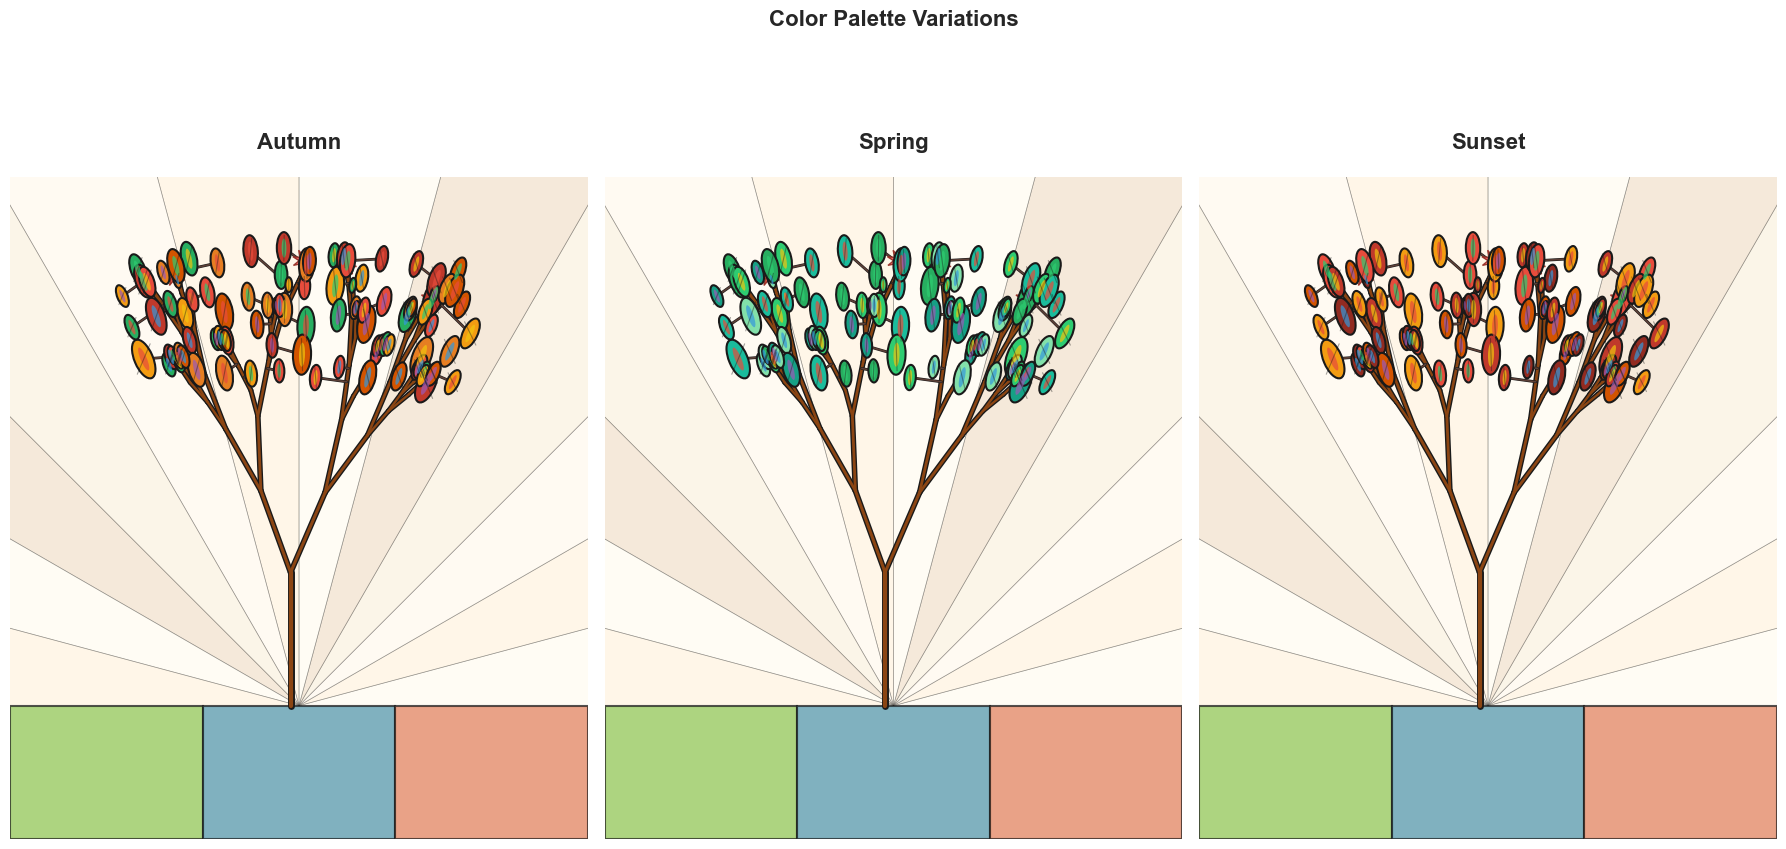

In [10]:
# Same tree, different palettes
palette_tree = create_grown_skeleton(depth=7, growth_stage=1.0, prune_fraction=0.2, seed=99)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

render_stained_glass_tree(palette_tree, ax=axes[0], palette=AUTUMN_PALETTE, leaf_density=140, title='Autumn')
render_stained_glass_tree(palette_tree, ax=axes[1], palette=SPRING_PALETTE, leaf_density=140, title='Spring')
render_stained_glass_tree(palette_tree, ax=axes[2], palette=SUNSET_PALETTE, leaf_density=140, title='Sunset')

plt.suptitle('Color Palette Variations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Growth Stage Animation

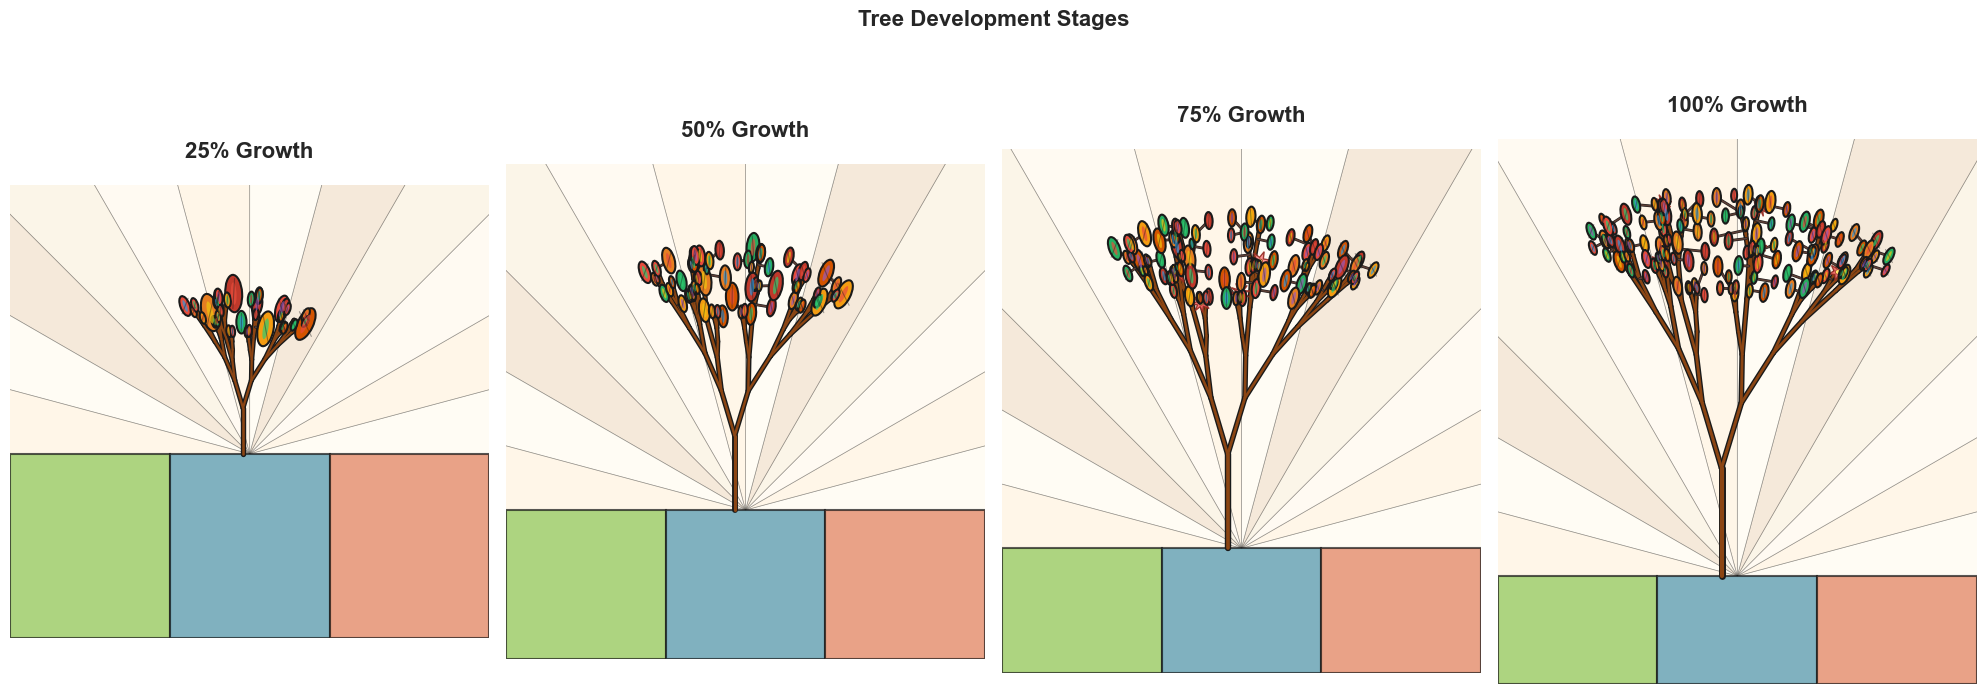

In [11]:
# Growth progression
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

stages = [0.25, 0.5, 0.75, 1.0]
for ax, stage in zip(axes, stages):
    tree = create_grown_skeleton(
        depth=7,
        growth_stage=stage,
        prune_fraction=0.15,
        seed=42,
    )
    render_stained_glass_tree(
        tree,
        ax=ax,
        leaf_density=int(120 * stage),
        leaf_size=0.08,
        title=f'{stage:.0%} Growth',
    )

plt.suptitle('Tree Development Stages', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Tree Gallery

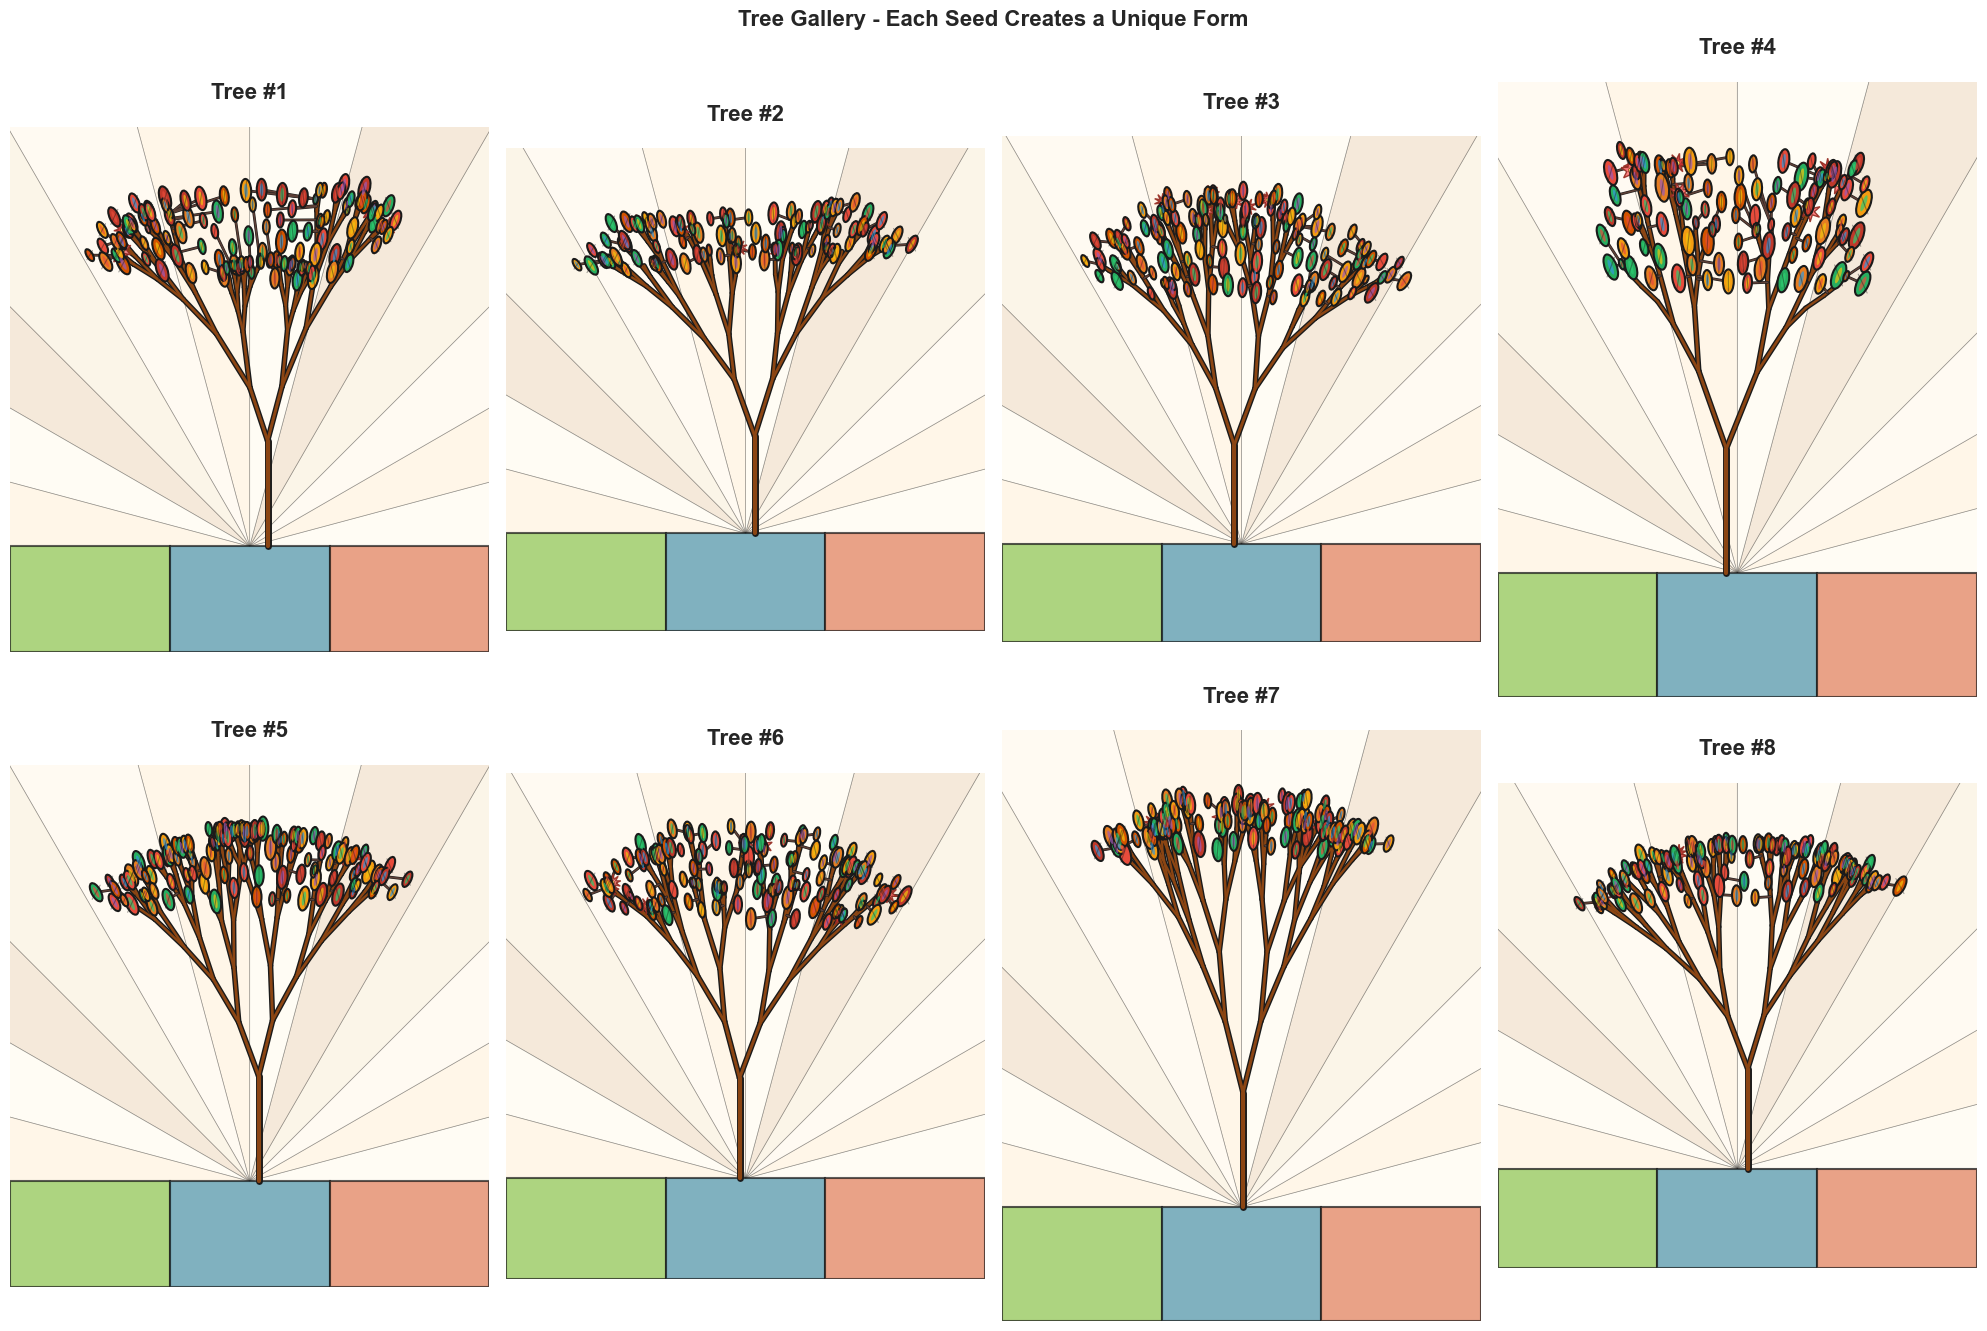

In [12]:
# Gallery of unique trees
fig, axes = plt.subplots(2, 4, figsize=(20, 14))
axes = axes.flatten()

for i, ax in enumerate(axes):
    seed = 100 + i * 23
    prune = 0.15 + 0.15 * np.sin(i * 0.7)
    tree = create_grown_skeleton(depth=7, prune_fraction=prune, jitter_strength=0.08, seed=seed)
    render_stained_glass_tree(tree, ax=ax, leaf_density=100, leaf_size=0.09, title=f'Tree #{i+1}', seed=seed)

plt.suptitle('Tree Gallery - Each Seed Creates a Unique Form', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('tree_gallery.png', dpi=150, bbox_inches='tight', facecolor='#FFF8DC')
plt.show()

## Summary

The geometric skeleton with stained-glass visualization provides:

1. **Spatial representation**: Tree form is explicit in 2D coordinates
2. **Light competition**: Self-shading model with Gaussian splats
3. **Wind exposure**: Orientation-based physics model
4. **Stress → Form**: Pruning fraction creates bonsai-like adaptations
5. **Poster aesthetics**: Lead-came branches, Poisson-sampled canopy, variegated leaves

**Next steps:**
- Connect skeleton dynamics to neural policy (spatial allocation)
- Train policy to optimize spatial growth under stress
- Animate growth over a season
- Add true Voronoi background panels